In [1]:
%matplotlib inline
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas
from matplotlib.gridspec import GridSpec
from matplotlib import ticker

from plot import bootstrap_samples_mean

plt.style.use('seaborn')
plt.style.use('seaborn-paper')
plt.rcParams.update({
    'figure.figsize': (3.6, 4.8),
    'text.usetex': True,
    'legend.borderpad': 0,
    'xtick.bottom': True,
    'xtick.major.size': 2,
    'xtick.minor.size': 1,
    'lines.markersize': 3,
    'lines.linewidth': 0.5,
    'errorbar.capsize': 4,
    'lines.markeredgewidth': 0.8
})

In [2]:
run_id = 'chembl_20220511'
zip = zipfile.ZipFile(f'../results/{run_id}.zip')

In [3]:
uind = pandas.read_csv(zip.open(f'{run_id}/uind.csv'))
uind['time'] /= 60
sampling = pandas.read_csv(zip.open(f'{run_id}/sampling.csv'))
sampling['time'] /= 60

In [4]:
uind_aggregated = uind.groupby('columns').aggregate('mean')

In [5]:
tind = pandas.read_csv(zip.open(f'{run_id}/bootstrap.csv'))
assert (len(tind) == len(uind))
tind['columns'] = uind['columns']
tind['time'] /= 60

In [6]:
tind_aggregated = tind.groupby('columns').aggregate('mean')

In [7]:
names = ['id', 'columns', 'exact', 'bootstrap_alpha', 'time', 'tests', 'ind', 'unique_ind', 'timeout'] + list(
    map(lambda i: f'max_{i}', range(9739)))

nind_ng = pandas.read_csv(zip.open(f'{run_id}/findg_0.05_1.00_0.csv'), sep=',', names=names, skiprows=1,
                          low_memory=False).dropna(axis=1, how='all')
nind_ng['time'] /= 60

In [8]:
nind_g = pandas.read_csv(zip.open(f'{run_id}/findg_0.05_1.00_1.csv'), sep=',', names=names, skiprows=1,
                         low_memory=False).dropna(axis=1, how='all')
nind_g['time'] /= 60

In [9]:
nind_ng_aggregated = nind_ng[~nind_ng['timeout']].groupby('columns').aggregate('mean')
nind_ng_timeouts = nind_ng[nind_ng['timeout']].groupby('columns').size()
nind_ng_timeouts /= nind_ng.groupby('columns').size()

In [10]:
nind_g_aggregated = nind_g[~nind_g['timeout']].groupby('columns').aggregate('mean')
nind_g_timeouts = nind_g[nind_g['timeout']].groupby('columns').size()
nind_g_timeouts /= nind_g.groupby('columns').size()

In [11]:
def compute_mean_err(df: pandas.DataFrame, col: str):
    mean = np.zeros(len(uind_aggregated.index))
    err = np.zeros_like(mean)
    for i, c in enumerate(uind_aggregated.index):
        subset = df[df['columns'] == c][col]
        if len(subset):
            samples = bootstrap_samples_mean(subset)
            mean[i], err[i] = np.mean(samples), np.std(samples)
    return mean, err

In [12]:
uind_mean, uind_err = compute_mean_err(uind, 'time')
tind_mean, tind_err = compute_mean_err(tind, 'time')
nind_ng_mean, nind_ng_err = compute_mean_err(nind_ng[~nind_ng['timeout']], 'time')
nind_g_mean, nind_g_err = compute_mean_err(nind_g[~nind_g['timeout']], 'time')

In [13]:
sampling_mean, sampling_err = compute_mean_err(sampling, 'time')

In [14]:
uind_accepted_mean, uind_accepted_err = compute_mean_err(uind, 'uinds')
tind_accepted_mean, tind_accepted_err = compute_mean_err(tind, 'accepted')
nind_ng_accepted_mean, nind_ng_accepted_err = compute_mean_err(nind_ng[~nind_ng['timeout']], 'unique_ind')
nind_g_accepted_mean, nind_g_accepted_err = compute_mean_err(nind_g[~nind_g['timeout']], 'unique_ind')

In [15]:
tind_candidate_mean, tind_candidate_err = compute_mean_err(tind, 'candidates')
nind_ng_candidate_mean, nind_ng_candidate_err = compute_mean_err(nind_ng[~nind_ng['timeout']], 'tests')
nind_g_candidate_mean, nind_g_candidate_err = compute_mean_err(nind_g[~nind_g['timeout']], 'tests')

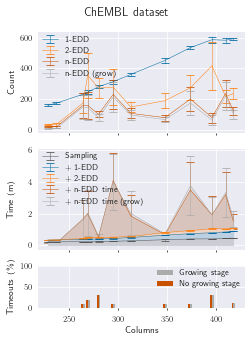

In [16]:
sampling_color = '#555555'
sampling_bg = '#ccccd3'
uind_color = '#006ba4'
uind_bg = '#bbd0e2'
tind_color = '#ff800e'
tind_bg = '#eed4c4'
nind_g_color = '#ababab'
nind_g_bg = '#dddde4'
nind_ng_color = '#c85200'
nind_ng_bg = '#d8c4bd'

fig = plt.figure()

gs = GridSpec(nrows=5, ncols=1)

# Counts
ax_counts = fig.add_subplot(gs[0:2, 0])
ax_counts.errorbar(uind_aggregated.index, uind_accepted_mean, yerr=uind_accepted_err, label='1-EDD',
                   color=uind_color)
ax_counts.errorbar(uind_aggregated.index, tind_accepted_mean, yerr=tind_accepted_err, label='2-EDD',
                   color=tind_color)
ax_counts.errorbar(uind_aggregated.index, nind_ng_accepted_mean, yerr=nind_ng_accepted_err,
                   label='n-EDD', color=nind_ng_color)
ax_counts.errorbar(uind_aggregated.index, nind_g_accepted_mean, yerr=nind_g_accepted_err,
                   label='n-EDD (grow)', color=nind_g_color)

ax_counts.legend()
ax_counts.set_ylabel('Count')
ax_counts.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax_counts.yaxis.grid(True, which='minor', linewidth=0.1)

plt.setp(ax_counts.get_xticklabels(), visible=False)

# Time
ax_time = fig.add_subplot(gs[2:4, 0], sharex=ax_counts)

ax_time.errorbar(uind_aggregated.index, sampling_mean, yerr=sampling_err, label='Sampling', color=sampling_color, zorder=10)
ax_time.fill_between(uind_aggregated.index, sampling_mean, color=sampling_bg, zorder=4)

ax_time.errorbar(uind_aggregated.index, sampling_mean + uind_mean, yerr=uind_err, label='+ 1-EDD', color=uind_color, zorder=10)
ax_time.fill_between(uind_aggregated.index, sampling_mean, uind_mean + sampling_mean, color=uind_bg, zorder=3)

ax_time.errorbar(uind_aggregated.index, sampling_mean + uind_mean + tind_mean, yerr=tind_err, label='+ 2-EDD',
                 color=tind_color, zorder=10)
ax_time.fill_between(uind_aggregated.index, sampling_mean + uind_mean, sampling_mean + uind_mean + tind_mean,
                     color=tind_bg, zorder=3)

ax_time.errorbar(uind_aggregated.index, uind_mean + tind_mean + nind_ng_mean, yerr=nind_ng_err, label='+ n-EDD time',
                 color=nind_ng_color)
ax_time.fill_between(uind_aggregated.index, uind_mean + tind_mean, uind_mean + tind_mean + nind_ng_mean, color=nind_ng_bg, zorder=2)

ax_time.errorbar(uind_aggregated.index, uind_mean + tind_mean + nind_g_mean, yerr=nind_g_err, label='+ n-EDD time (grow)',
                 color=nind_g_color)
ax_time.fill_between(uind_aggregated.index, uind_mean + tind_mean, uind_mean + tind_mean + nind_g_mean, color=nind_g_bg, zorder=1)

ax_time.legend(loc='upper left')
ax_time.set_ylabel('Time (m)')

ax_time.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax_time.yaxis.grid(True, which='minor', linewidth=0.1)

plt.setp(ax_time.get_xticklabels(), visible=False)

ax_timeouts = fig.add_subplot(gs[4, 0], sharex=ax_counts)
ax_timeouts.bar(nind_g_timeouts.index+1, nind_g_timeouts * 100, width=2, color=nind_g_color, label='Growing stage')
ax_timeouts.bar(nind_ng_timeouts.index-1, nind_ng_timeouts * 100, width=2, color=nind_ng_color, label='No growing stage')
ax_timeouts.legend()

ax_timeouts.set_ylabel('Timeouts (\%)')
ax_timeouts.set_xlabel('Columns')
ax_timeouts.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax_timeouts.yaxis.grid(True, which='minor', linewidth=0.1)
ax_timeouts.set_ylim(0, 100)

plt.suptitle('ChEMBL dataset')

fig.align_ylabels([ax_counts, ax_time, ax_timeouts])

plt.tight_layout()
plt.savefig('/home/aalvarez/Downloads/scalability_columns_chembl.eps', bbox_inches='tight', pad_inches=0.05)
plt.show()